# Topic: Research Papers Categorization 

In this notebook i have experiemented with Data preprocessing techniques by including:

- Removal of stopwords
- Lemmatization


# Step 1: Data Visualization


In this step i am checking for null values, distribution of labels and balance of the data across the labels

In [1]:
#importing all the dependencies
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Path of the :
- Test and Train data
- GloVe embedding file 
- Saved model

**change the path to run the experiement in your local**
(Note: I am loading the absolute path as it was throwing error as file not found) 

In [19]:
train_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/train.csv')
test_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/test.csv')

modelpath_WithDataPreVar="C:\\Users\\priyanka\\OneDrive - University of Surrey\\NLPCourseWork\\ModelWithDataPreVar.hdf5"
glovepath_file='C:\\Users\\priyanka\\OneDrive - University of Surrey\\NLPCourseWork\\glove.6B.100d.txt'

In [3]:
print("Number of rows in data =",train_respapers.shape[0])
print("Number of columns in data =",train_respapers.shape[1])
print("\n")
print("**Sample data:**")
train_respapers.head()

Number of rows in data = 20972
Number of columns in data = 9


**Sample data:**


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
#check for missing values
missing_values_check = train_respapers.isnull().sum()
print("Check for Missing values:\n ")
print(missing_values_check)

Check for Missing values:
 
ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64


There are no any null or missing values in data and all the labels are tagged to data

In [5]:
#Check for the Papers without labels
rowSums = train_respapers.iloc[:,3:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of papers = ",len(train_respapers))
print("Number of papers with labels =",(len(train_respapers)-clean_comments_count))

Total number of papers =  20972
Number of papers with labels = 20972


In [6]:
#print the list of Target labels
categories = list(train_respapers.columns.values)
categories = categories[3:]
print("List of Labels: ",categories)

List of Labels:  ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [7]:
# Calculating number of research papers in each category
counts = []
for category in categories:
    counts.append((category, train_respapers[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Research Category', 'Number of Papers'])
print(df_stats)

      Research Category  Number of Papers
0      Computer Science              8594
1               Physics              6013
2           Mathematics              5618
3            Statistics              5206
4  Quantitative Biology               587
5  Quantitative Finance               249


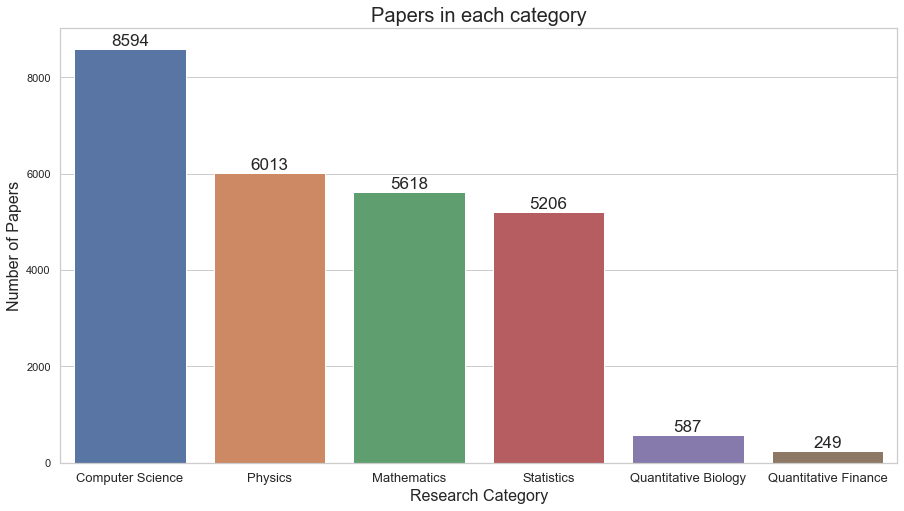

In [8]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax= sns.barplot(x=categories, y=train_respapers.iloc[:,3:].sum().values)

plt.title("Papers in each category", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Research Category', fontsize=16)

#adding the text labels
rects = ax.patches
labels = train_respapers.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=17)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
plt.show()

The data is very imbalanced with only 587 records with "Quantitative Biology" and 249 records with "Quantitative Finance"

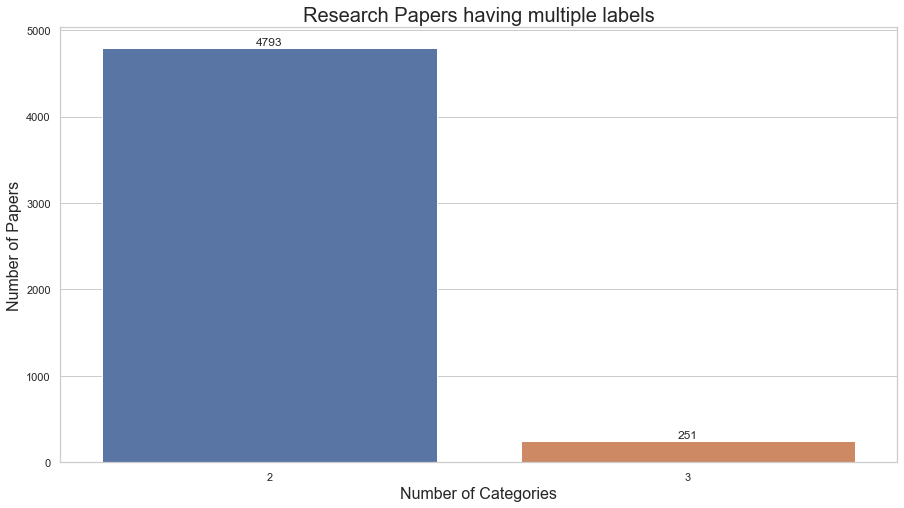

In [9]:
rowSums = train_respapers.iloc[:,2:].sum(axis=1)

multiLabel_counts = rowSums.value_counts().iloc[1:]

plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Research Papers having multiple labels", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Number of Categories', fontsize=16)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In the above plot, I am trying show the no. of records having more than one categories where 4793 records have 2 categories and 251 records have 3 categories

# Step 2 : Data Preprocessing

I am performing below data preprocessing of input label which is ' **ABSTRACT** ':

- Remove Punctuation
- Decontracting the text
- Remove Stop words
- Lemmatization
- Tokenizing
- De-tokenizing

In [10]:
# Load the regular expression library and spacy library
import re
import spacy
import gensim
from gensim.utils import simple_preprocess
from nltk.tokenize.treebank import TreebankWordDetokenizer
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Remove punctuation
def remove_punctuation(text):
    text = re.sub('[,\.!?]', '', text)
    return text

#tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) 
        
#remove stopwords        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# decontract the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = text.strip(' ')
    return text


#Lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priyanka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#decontract the text
train_respapers['body_cleantext'] = train_respapers['ABSTRACT'].apply(lambda x: clean_text(x))
#Remove punctuation
train_respapers['body_text_nopunc'] = train_respapers['body_cleantext'].apply(lambda x: remove_punctuation(x))
data = train_respapers['body_text_nopunc'].values.tolist()
#Tokenization
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
#Lemmatization
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
train_respapers["new_abstract"]=data_lemmatized
train_respapers["ABSTRACT_detokenize"]=train_respapers["new_abstract"].apply(lambda x: detokenize(x))
#detokenize 
train_respapers["ABSTRACT"]=train_respapers["ABSTRACT_detokenize"]
train_respapers.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,body_cleantext,body_text_nopunc,new_abstract,ABSTRACT_detokenize
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow specific inference anal...,1,0,0,0,0,0,predictive models allow subject-specific infer...,predictive models allow subject-specific infer...,"[predictive, model, allow, specific, inference...",predictive model allow specific inference anal...
1,2,Rotation Invariance Neural Network,rotation invariance translation invariance gre...,1,0,0,0,0,0,rotation invariance and translation invariance...,rotation invariance and translation invariance...,"[rotation, invariance, translation, invariance...",rotation invariance translation invariance gre...
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0,we introduce and develop the notion of spheric...,we introduce and develop the notion of spheric...,"[introduce, develop, notion, spherical, polyha...",introduce develop notion spherical polyharmoni...
3,4,A finite element approximation for the stochas...,stochastic couple maxwell equation call system...,0,0,1,0,0,0,the stochastic landau--lifshitz--gilbert (llg)...,the stochastic landau--lifshitz--gilbert (llg)...,"[stochastic, couple, maxwell, equation, call, ...",stochastic couple maxwell equation call system...
4,5,Comparative study of Discrete Wavelet Transfor...,fouri red ftir sample plant specie use explore...,1,0,0,1,0,0,fourier-transform infra-red (ftir) spectra of ...,fourier-transform infra-red (ftir) spectra of ...,"[fouri, red, ftir, sample, plant, specie, use,...",fouri red ftir sample plant specie use explore...


In [13]:
train_respapers = train_respapers.drop(columns=['body_text_nopunc','body_cleantext', 'new_abstract','ABSTRACT_detokenize'], axis=1)
train_respapers.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,predictive model allow specific inference anal...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance translation invariance gre...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,stochastic couple maxwell equation call system...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fouri red ftir sample plant specie use explore...,1,0,0,1,0,0


In [14]:
research_labels = train_respapers[["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]]
research_labels_val=research_labels.values
print(research_labels_val)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


# Step 3: Prepare the Data

- Splitting the dataset
- Tokenizing the text with texts_to_sequence to transform words to numbers 
- Using Pad_sequences to ensure all the vectors are of same length
- Creating the embedding matrix with pre-trained word embedding GloVe

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
train_respapers['ABSTRACT'], research_labels_val, test_size=0.3, random_state=1234, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14680,)
(14680, 6)
(6292,)
(6292, 6)


In [16]:
#Split the text to tokens, using most 5000 frequent words and max len to 200
tokenizer = Tokenizer(num_words=5000,lower=True)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Vocabulary size is ",vocab_size)

Vocabulary size is  25696


In [17]:
#function to create a embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [20]:
#Defining the embedding_dim to 100 for Glove and calling the function to create the 
#embedding matix which goes into the embedding layer
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
     glovepath_file,
     tokenizer.word_index, embedding_dim)
print('found %s word vectors' % len(embedding_matrix))

found 25696 word vectors


# Step 4: Build the Model

- I am creating the model with configurable parameter of pre-training embedding true or false

- Creating the sequential model with

  - Single LSTM layer with 0.2 of dropout to prevent the overfitting
  - Dense layer with 6 outputs (6labels) with Sigmoid activation because my output is binary(0 or 1)

In [21]:
# function that defines the model
from keras import Sequential, Model
from keras.layers import Embedding,LSTM, GlobalMaxPool1D,Conv1D,Bidirectional
from keras.optimizers import Adam, SGD
def get_model(pretrainedembedding):
    model = Sequential()
    if(pretrainedembedding==True):
        model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=False ,input_length=maxlen))
      
    else:
        model.add(Embedding(vocab_size, embedding_dim ,input_length=maxlen))
        
    #model.add(Dropout(0.2))
    #model.add(LSTM(128,name='lstm_layer',dropout=0.6))
    model.add(LSTM(128,name='lstm_layer',dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='sigmoid'))
    return model
   

- I have defined the callback function to save the best model when validation loss is less
- I am using 'binary_crossentropy' as i am classifying the multiple labels as my loss function with accuracy metric

In [22]:
from keras.callbacks import ModelCheckpoint
def fit_model(model,path,opt):
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    cm_callback = ModelCheckpoint(path, save_best_only = True, monitor = 'val_loss', verbose = 1)
#cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2,
                  callbacks=[cm_callback],validation_data=(X_test, y_test))
    return(history)

In [23]:
model_WithDataPreVar = get_model(pretrainedembedding=True)
print(model_WithDataPreVar.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2569600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 2,687,622
Trainable params: 118,022
Non-trainable params: 2,569,600
_________________________________________________________________
None


# Step 5: Train the Model

Defines below three function:

- Evaluate the model against the test data
- To calculate the confusion matrix
- Plot the metrics (loss vs epoch) and (accuracy vs epoch) for train and test data

In [24]:
# takes path and message as the parameters to save the model and print the custom message
import keras
def evaluate(path,msg):
    lstm_model = keras.models.load_model(path)
    test_evaluate = lstm_model.evaluate(X_test, y_test, verbose=1)
    print("Research Papers Test Score :" +msg, test_evaluate[0])
    print("Research Papers Test Accuracy :" +msg, test_evaluate[1])

In [25]:
# takes path and message as the parameters to save the model and print the custom message
from sklearn.metrics import multilabel_confusion_matrix,classification_report
def confusion_matrix(path,msg):
    lstm_model = keras.models.load_model(path)
    Y_pred = lstm_model.predict(X_test)
    Y_pred  = np.where(Y_pred > 0.5, 1, 0)
    print('Confusion Matrix of - ',msg)
    target_names = ['Computer Science', 'Physics', 'Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
    confusionmatrix=multilabel_confusion_matrix(y_test, Y_pred)
    print(confusionmatrix)
    print('Classification Report')
    print(classification_report(y_test, Y_pred, target_names=target_names,zero_division=0))
    print("confusion matrix function")

In [30]:
# takes history of the fitted model and message as the parameters 
import matplotlib.pyplot as plt
def plotmetrics(history,msg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy - '+msg)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss - '+msg)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

**Fit and Evaluate the model**

In [26]:
model_WithDataPreVar_his=fit_model(model_WithDataPreVar,modelpath_WithDataPreVar,'adam')

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpmbmd53i9.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpmbmd53i9.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
367/367 [==============================] - 36s 66ms/step - loss: 0.4726 - accuracy: 0.3776 - val_loss: 0.4362 - val_accuracy: 0.4029

Epoch 00001: val_loss improved from inf to 0.43615, saving model to C:\Users\priyanka\OneDrive - University of Surrey\NLPCourseWork\ModelWithDataPreVar.hdf5
Epoch 2/10
367/367 [==============================] - 24s 65ms/step - loss: 0.4387 - accuracy:

In [27]:
print("The path of the saved model is "+modelpath_WithDataPreVar)
evaluate(modelpath_WithDataPreVar,"(Model with Pretrained Embedding)")
confusion_matrix(modelpath_WithDataPreVar,"for model with pretrained embedding")

The path of the saved model is C:\Users\priyanka\OneDrive - University of Surrey\NLPCourseWork\ModelWithDataPreVar.hdf5
197/197 [==============================] - 5s 24ms/step - loss: 0.4345 - accuracy: 0.4153
Research Papers Test Score :(Model with Pretrained Embedding) 0.4344973564147949
Research Papers Test Accuracy :(Model with Pretrained Embedding) 0.4152892529964447
Confusion Matrix of -  for model with pretrained embedding
[[[3679    0]
  [2613    0]]

 [[4482    0]
  [1810    0]]

 [[4634    0]
  [1658    0]]

 [[4759    0]
  [1533    0]]

 [[6114    0]
  [ 178    0]]

 [[6216    0]
  [  76    0]]]
Classification Report
                      precision    recall  f1-score   support

    Computer Science       0.00      0.00      0.00      2613
             Physics       0.00      0.00      0.00      1810
         Mathematics       0.00      0.00      0.00      1658
          Statistics       0.00      0.00      0.00      1533
Quantitative Biology       0.00      0.00      0.00  

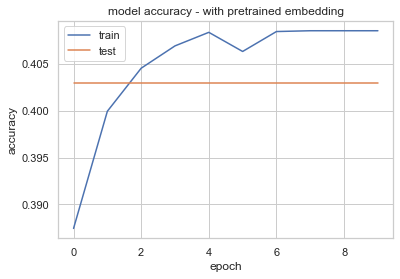

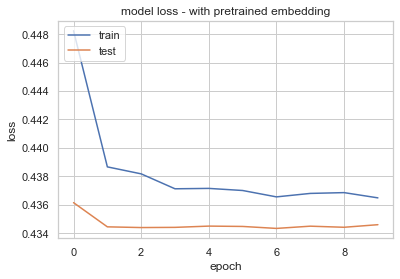

In [31]:
plotmetrics(model_WithDataPreVar_his,"with pretrained embedding")

**Conclusion :**

- From the results i can infer that the Stopwords, lemmatizing technique leading to low learning rate of this model
- Model is overfitting with unable to learn for the test data
   
  